In [127]:
# Data preparation
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

plot_info = []
src_data_dir = "../utils/multi-gen-result"

for root, sub_dir, files in os.walk(src_data_dir):
    for file in files:
        if file.endswith(".csv"):
            try:
                src_file = os.path.join(root,file)
                dim = int(file[3])
                obj = int(file[9])
                tree = file[16:].strip(".csv").split("_")[0]
                gen = int(file.strip(".csv")[-3:])
                df = pd.read_csv(src_file,index_col=0).fillna(0)
                df["dimension"] = dim
                df["n_objectives"] = obj
                df["tree"] = tree
                df["gen"] = gen
                plot_info.append(df)
            except Exception as e:
                pass
            
            
new_df = pd.concat(plot_info)
solvers = ["MOEAD","NSGAII","GDE3","IBEA"]
dimensions = [2,3,4,5]
n_objectives = [2,3,4,5]
trees = ["depth","breadth"]
df_info = []
for tree in trees:
    for dimension in dimensions:
        for n_objective in n_objectives:
            for solver in solvers:
                filtered_df = new_df[(new_df["solver"]==solver) & (new_df["dimension"]==dimension)&(new_df["tree"]==tree)&(new_df["n_objectives"]==n_objective)]
                if not filtered_df.empty:
                    df_info.append({
                        "solver":solver,
                        "dimX":dimension,
                        "dimZ":n_objective,
                        "tree":tree,
                        "root_mean":filtered_df["root"].mean(),
                        "root_std":filtered_df["root"].std(),
                        "node_1_mean":filtered_df["node_1"].mean(),
                        "node_1_std":filtered_df["node_1"].std(),
                        "node_2_mean":filtered_df["node_2"].mean(),
                        "node_2_std":filtered_df["node_2"].std(),
                        "node_3_mean":filtered_df["node_3"].mean(),
                        "node_3_std":filtered_df["node_3"].std(),
                        "node_4_mean":filtered_df["node_4"].mean(),
                        "node_4_std":filtered_df["node_4"].std(),
                    })

stats_df = pd.DataFrame(df_info)    

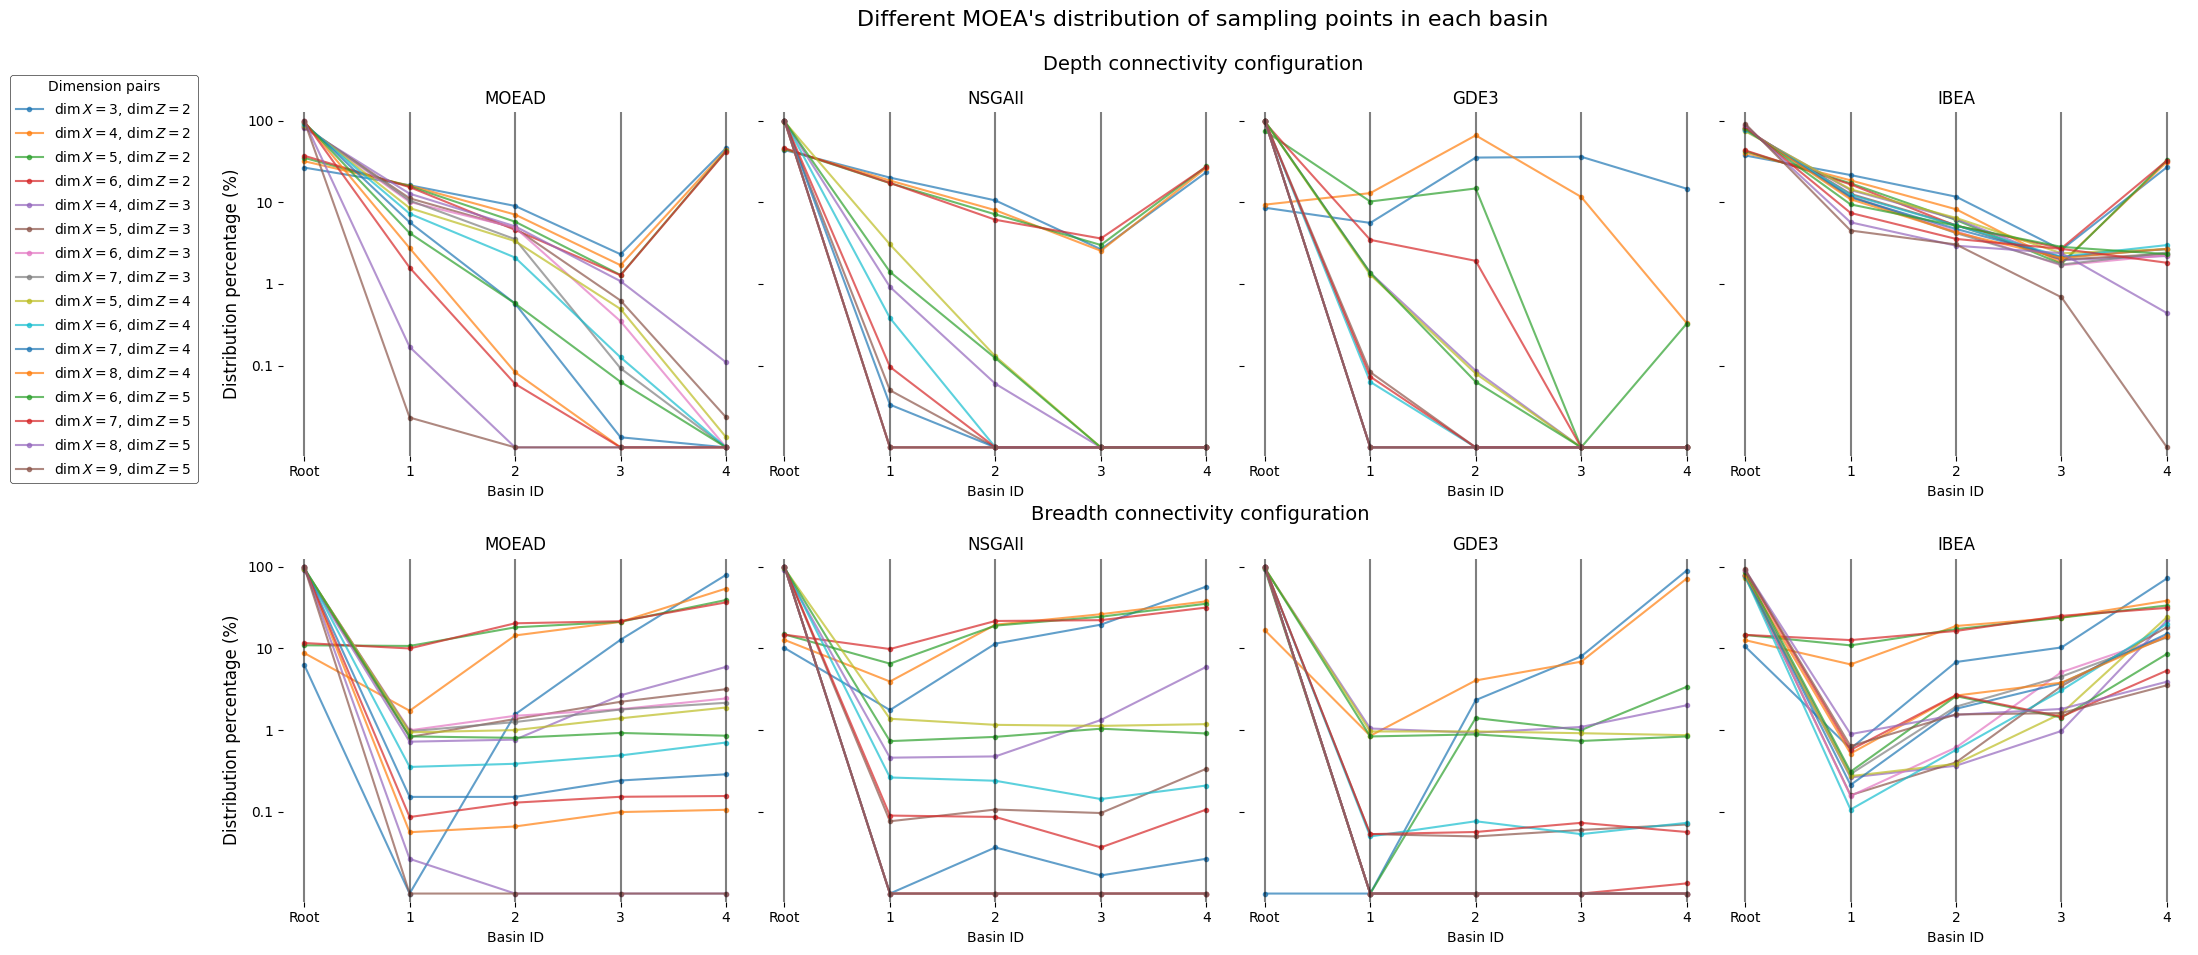

In [173]:
solvers = ["MOEAD","NSGAII","GDE3","IBEA"]

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.ravel()

row_labels = []
row_label_flag = False
for i, ax in enumerate(axs):
    solver = solvers[i % 4]
    if i <= 3:
        tree = trees[0]
    else:
        tree = trees[1]
    plotting_df = stats_df[(stats_df["solver"]==solver) & (stats_df["tree"]==tree)].copy()
    plotting_df["agg_dimX"] = plotting_df['dimX'] + plotting_df['dimZ'] - 1
    plotting_df.sort_values(by=["dimZ","agg_dimX"],ascending=[True,True], inplace=True)
    plotting_df.reset_index(inplace=True)
    plotting_df_log = plotting_df[["root_mean","node_1_mean","node_2_mean","node_3_mean","node_4_mean"]]
    
    plotting_df_log = np.log10(plotting_df_log.replace(0, np.nan)) # Log transform, avoiding log(0)

    plotting_df_log.fillna(-2,inplace=True)
    plotting_df_log.where(plotting_df_log > -2, -2, inplace=True)

    num_vars = len(plotting_df_log.columns) 
    plotting_df_log["dimX"] = plotting_df["dimX"]
    plotting_df_log["dimZ"] = plotting_df["dimZ"]
    
    x = range(num_vars)
                           
    for idx, row in plotting_df_log.iterrows():
        y = row.to_list()[:-2]
        row_label = f"$\operatorname{{dim}}X={int(row['dimX'] + row['dimZ'] - 1)}$, $\operatorname{{dim}}Z={int(row['dimZ'])}$"
        if not row_label_flag:
            row_labels.append(row_label)
        ax.plot(x, y, marker='.', label=row_label, alpha=0.7)  # Each line labeled with row label
        
    row_label_flag = True

    ax.set_title(solver)

    ax.set_xticks(ticks=x)
    ax.set_xticklabels(["Root","1","2","3","4"])  # Set the labels for each axis

    for j in x:
        ax.vlines(j, -2.1, 2.1, color='black', alpha=0.5)  # Extend the vertical lines based on log scale

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-2.1, 2.1)  # Log10 of 0.1 is -1, and Log10 of 100 is 2
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_yticklabels([0.1, 1, 10, 100])
    ax.set_xlabel('Basin ID')
    
axs[0].set_ylabel('Distribution percentage (%)', fontsize=12)
axs[4].set_ylabel('Distribution percentage (%)', fontsize=12)
    
legend = fig.legend(title="Dimension pairs", labels=row_labels, loc='lower left', bbox_to_anchor=(-0.1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')  # Set the edge color of the frame
legend.get_frame().set_linewidth(0.5)      # Set the line width of the frame

fig.suptitle("Different MOEA's distribution of sampling points in each basin", fontsize=16)
fig.text(0.5, 0.92, 'Depth connectivity configuration', ha='center', fontsize=14)  # Title for the first row
fig.text(0.5, 0.47, 'Breadth connectivity configuration ', ha='center', fontsize=14)  # Title for the second row

plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])  # Adjust the layout to fit titles and legend
plt.subplots_adjust(left=0.04,hspace=0.3)  # Adjust space to make room for the left legend
plt.savefig("log_parallel.pdf",format="pdf", bbox_inches="tight")

plt.show()


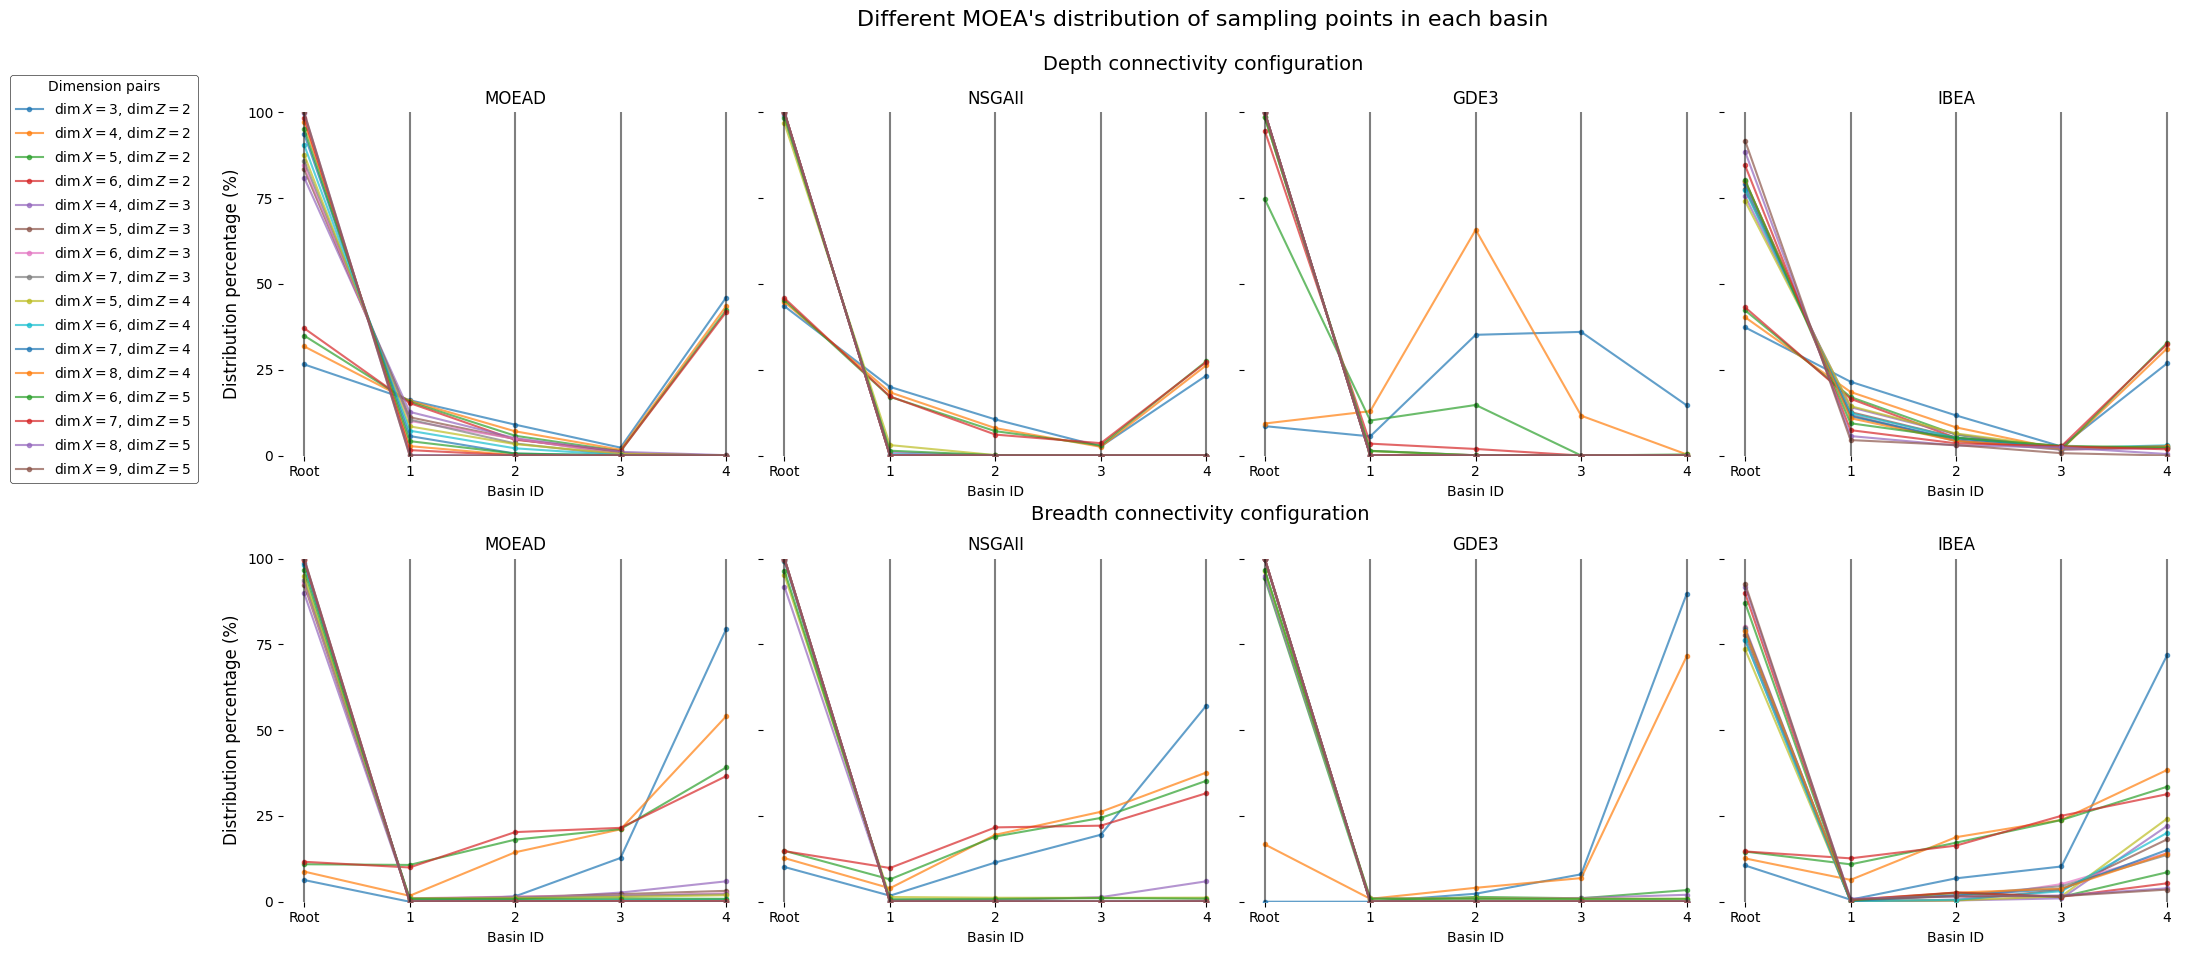

In [172]:
solvers = ["MOEAD", "NSGAII", "GDE3", "IBEA"]

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.ravel()

row_labels = []
row_label_flag = False

for i, ax in enumerate(axs):
    solver = solvers[i % 4]
    if i <= 3:
        tree = trees[0]
    else:
        tree = trees[1]
    
    # Filter data for the specific solver and tree
    plotting_df = stats_df[(stats_df["solver"] == solver) & (stats_df["tree"] == tree)].copy()
    plotting_df["agg_dimX"] = plotting_df['dimX'] + plotting_df['dimZ'] - 1
    plotting_df.sort_values(by=["dimZ", "agg_dimX"], ascending=[True, True], inplace=True)
    plotting_df.reset_index(inplace=True)
    
    # Linear scale: Directly use the original data (no log transform)
    plotting_df_linear = plotting_df[["root_mean", "node_1_mean", "node_2_mean", "node_3_mean", "node_4_mean"]].copy()
    
    # Ensure no negative values or NaNs (if needed)
    plotting_df_linear.fillna(0, inplace=True)

    num_vars = len(plotting_df_linear.columns) 
    plotting_df_linear["dimX"] = plotting_df["dimX"]
    plotting_df_linear["dimZ"] = plotting_df["dimZ"]
    
    x = range(num_vars)
    
    for idx, row in plotting_df_linear.iterrows():
        y = row.to_list()[:-2]  # Get the values without 'dimX' and 'dimZ'
        row_label = f"$\operatorname{{dim}}X={int(row['dimX'] + row['dimZ'] - 1)}$, $\operatorname{{dim}}Z={int(row['dimZ'])}$"
        if not row_label_flag:
            row_labels.append(row_label)
        ax.plot(x, y, marker='.', label=row_label, alpha=0.7)  # Each line labeled with row label
        
    row_label_flag = True

    ax.set_title(solver)

    ax.set_xticks(ticks=x)
    ax.set_xticklabels(["Root", "1", "2", "3", "4"])  # Set the labels for each axis

    for j in x:
        ax.vlines(j, 0, 100, color='black', alpha=0.5)  # Extend the vertical lines (0 to 100 range for linear)

    # Adjust the axis appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_ylim(0, 100)  # Linear scale range (0 to 100)
    ax.set_yticks([0, 25, 50, 75, 100])  # Adjust y-axis ticks for linear scale
    ax.set_yticklabels([0, 25, 50, 75, 100])  # Linear scale labels (0 to 100)
    ax.set_xlabel('Basin ID')
    
# Set y-axis labels for the first subplot of each row
axs[0].set_ylabel('Distribution percentage (%)', fontsize=12)
axs[4].set_ylabel('Distribution percentage (%)', fontsize=12)
    
# Add the legend on the left with an outer frame
legend = fig.legend(title="Dimension pairs", labels=row_labels, loc='lower left', bbox_to_anchor=(-0.1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')  # Set the edge color of the frame
legend.get_frame().set_linewidth(0.5)      # Set the line width of the frame

# Add titles
fig.suptitle("Different MOEA's distribution of sampling points in each basin", fontsize=16)
fig.text(0.5, 0.92, 'Depth connectivity configuration', ha='center', fontsize=14)  # Title for the first row
fig.text(0.5, 0.47, 'Breadth connectivity configuration ', ha='center', fontsize=14)  # Title for the second row

# Adjust layout to fit titles and legend
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])  # Adjust the layout to fit titles and legend
plt.subplots_adjust(left=0.04, hspace=0.3)  # Adjust space to make room for the left legend
plt.savefig("linear_parallel.pdf",format="pdf", bbox_inches="tight")
plt.show()